In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import sqlite3

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
conn = sqlite3.connect('C:/Users/varal/Downloads/mimic.db/mimic.db')

In [108]:
# Primary Admissions information
df = pd.read_sql('select * from admissions',conn)

# Patient specific info such as gender
df_pat = pd.read_sql('select * from patients',conn)

# Diagnosis for each admission to hospital
df_diagcode = pd.read_sql('select * from diagnoses_icd',conn)
# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_sql('select * from icustays',conn)

In [109]:
# her all admissions for patients 
ad_patients = pd.read_sql('select *, (julianday(date(admittime))-julianday(date(dob)))/365.25 as age from admissions, patients where admissions.subject_id = patients.subject_id ',conn)

In [110]:
df.shape

(58976, 19)

In [111]:
df['SUBJECT_ID'].nunique()
# 46520 unique patients

46520

In [112]:
import time
# calculate los in seconds
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [113]:
# calculating next admission type and record
df['NEXT_ADM'] = df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df['NEXT_ADM_TYPE'] = df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [114]:
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df['NEXT_ADM'] = pd.to_datetime(df['NEXT_ADM'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# Calculating Number of days between dischare and readmission
df['NEXT_ADMIT_DAYS'] = (df['NEXT_ADM'] - df['DISCHTIME']).dt.total_seconds()/(24*60*60)

In [115]:
readmission_30 = []
for index,row in df.iterrows():
        if(row['NEXT_ADMIT_DAYS']<=30):
            readmission_30.append(1)
        else:
            readmission_30.append(0)
df['Readmission_30'] = readmission_30

In [116]:
#df = df[df['LOS']>0]

Text(0, 0.5, 'Number of Records')

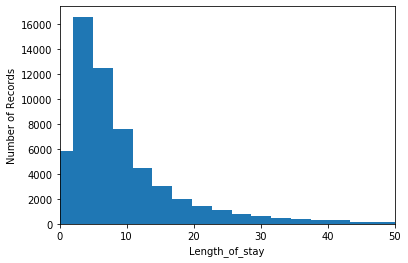

In [117]:
plt.hist(df['LOS'],bins= 100)
plt.xlim(0,50)
plt.xlabel('Length_of_stay')
plt.ylabel('Number of Records')

In [118]:
df = df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'])

In [119]:
# replacing empty space with null value
df['DEATHTIME'] = df['DEATHTIME'].replace(r'^\s*$', np.nan, regex=True)

In [120]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

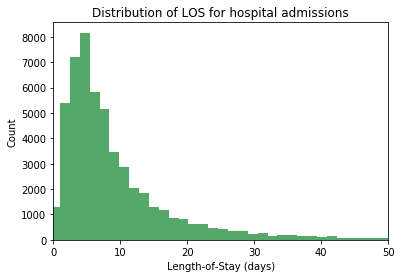

In [121]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [122]:
df['ETHNICITY'].value_counts()

WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [123]:
# EHNICITY
temp = []
for index,row in df.iterrows():
    a = row['ETHNICITY']
    b = list(a.split('-'))
    temp.append(b[0])
df['ETHNICITY'] = temp

In [124]:
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["AMERICAN INDIAN/ALASKA NATIVE","AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE",
                                                                       "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER","CARIBBEAN ISLAND","SOUTH AMERICAN","WHITE"], value = "WHITE")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["BLACK/CAPE VERDEAN", "BLACK/AFRICAN", "BLACK/HAITIAN"], value = "BLACK")
df["ETHNICITY"] = df['ETHNICITY'].replace(to_replace = ["UNKNOWN/NOT SPECIFIED","UNABLE TO OBTAIN","PORTUGUESE",
                                                                       "MULTI RACE ETHNICITY","MIDDLE EASTERN","NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER",
                                                                       "CARIBBEAN ISLAND"], value = "OTHERS")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["PATIENT DECLINED TO ANSWER","OTHER","OTHERS"], value = "OTHERS")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["WHITE","WHITE"], value = 'WHITE')
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["HISPANIC OR LATINO","HISPANIC/LATINO"], value = "HISPANIC")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["ASIAN - OTHER","ASIAN - CAMBODIAN","ASIAN - VIETNAMESE","ASIAN - FILIPINO",
                                                                       "ASIAN - ASIAN INDIAN","ASIAN - CHINESE","ASIAN"], value = "ASIAN")

In [125]:
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["WHITE","WHITE "], value="WHITE")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["ASIAN","ASIAN "],value = "ASIAN")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["BLACK/AFRICAN AMERICAN","BLACK"], value = "BLACK")
df['ETHNICITY'] = df['ETHNICITY'].replace(to_replace = ["HISPANIC","HISPANIC/LATINO "], value = "HISPANIC")

In [126]:
df.groupby('ETHNICITY').mean()

,LOS,NEXT_ADMIT_DAYS,Readmission_30,DECEASED
ETHNICITY,,,,
ASIAN,9.038504,345.056075,0.057299,0.075735
BLACK,10.270289,331.532065,0.091616,0.072774
HISPANIC,9.964996,338.986135,0.058741,0.056391
OTHERS,10.562660,522.940413,0.034415,0.140539
WHITE,10.097517,399.056761,0.058724,0.098686


In [127]:
df.groupby('MARITAL_STATUS').mean()
#df.columns

,LOS,NEXT_ADMIT_DAYS,Readmission_30,DECEASED
MARITAL_STATUS,,,,
,11.060314,184.550704,0.027152,0.065265
DIVORCED,10.333638,346.009773,0.069717,0.099284
LIFE PARTNER,7.909306,296.723264,0.000000,0.000000
MARRIED,9.960506,435.847789,0.062544,0.107678
SEPARATED,10.712014,363.289060,0.096322,0.094571
SINGLE,10.028411,344.435950,0.071073,0.082390
UNKNOWN (DEFAULT),11.238098,431.449251,0.040580,0.188406
WIDOWED,9.426623,415.268631,0.060879,0.146027


In [128]:
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())

RELIGIOUS        38954
NOT SPECIFIED    11753
UNOBTAINABLE      8269
Name: RELIGION, dtype: int64


In [129]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

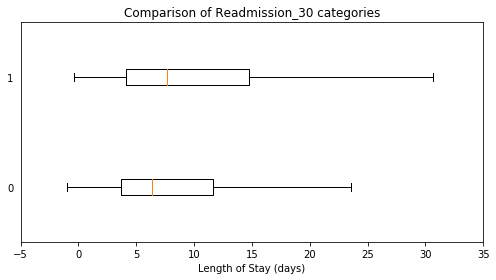

In [130]:
boxplot_los_groupby('Readmission_30', los_range=(-5, 35), size=(7, 4))

In [131]:
df_diagcode.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [132]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['code'] = df_diagcode['ICD9_CODE']
df_diagcode['code'] = df_diagcode['code'][~df_diagcode['code'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['code'].fillna(value='999', inplace=True)
df_diagcode['code'] = df_diagcode['code'].str.slice(start=0, stop=3, step=1)
df_diagcode[['code']] = df_diagcode[['code']].apply(pd.to_numeric)


# ICD-9 Important Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['code'] = np.where(df_diagcode['code'].between(cat_range[0],cat_range[1]),
            num, df_diagcode['code'])

# Convert integer to category name using diag_dict
df_diagcode['code'] = df_diagcode['code']
df_diagcode['category'] = df_diagcode['code'].replace(diag_dict)

In [133]:
# list of diagnosis for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['category'].apply(list).reset_index()
hadm_list

,HADM_ID,category
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."
...,...,...
58971,199993,"[circulatory, circulatory, circulatory, circul..."
58972,199994,"[respiratory, circulatory, respiratory, circul..."
58973,199995,"[circulatory, congenital, circulatory, mental,..."
58974,199998,"[circulatory, injury, injury, circulatory, mis..."


In [134]:
# Duplicating the list of categories
hadm_item = pd.get_dummies(hadm_list['category'].apply(pd.Series).stack()).sum(level=0)
# joining HADM_ID to the hadm_item
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0.0,2.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,100001
1,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100003
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,100006
3,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100007
4,1.0,7.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100009


In [135]:
# Merge with data
df = df.merge(hadm_item, on = 'HADM_ID', how='inner')

In [136]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'LOS',
       'NEXT_ADM', 'NEXT_ADM_TYPE', 'NEXT_ADMIT_DAYS', 'Readmission_30',
       'DECEASED', 'blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
       'respiratory', 'skin'],
      dtype='object')

In [137]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']


In [138]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [139]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'LOS',
       'NEXT_ADM', 'NEXT_ADM_TYPE', 'NEXT_ADMIT_DAYS', 'Readmission_30',
       'DECEASED', 'blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
       'respiratory', 'skin', 'DOB', 'GENDER', 'ADMIT_MIN'],
      dtype='object')

In [140]:
df['DOB'] = pd.to_datetime(df['DOB'])

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          58976 non-null  object        
 1   HADM_ID             58976 non-null  object        
 2   ADMITTIME           58976 non-null  datetime64[ns]
 3   DEATHTIME           5854 non-null   datetime64[ns]
 4   ADMISSION_TYPE      58976 non-null  object        
 5   ADMISSION_LOCATION  58976 non-null  object        
 6   DISCHARGE_LOCATION  58976 non-null  object        
 7   INSURANCE           58976 non-null  object        
 8   LANGUAGE            58976 non-null  object        
 9   RELIGION            58976 non-null  object        
 10  MARITAL_STATUS      58976 non-null  object        
 11  ETHNICITY           58976 non-null  object        
 12  DIAGNOSIS           58976 non-null  object        
 13  LOS                 58976 non-null  float64   

In [142]:
# replacing empty space with null value
df['ADMIT_MIN'] = df['ADMIT_MIN'].replace(r'^\s*$', np.nan, regex=True)

In [143]:
# replacing empty space with null value
df['DOB'] = df['DOB'].replace(r'^\s*$', np.nan, regex=True)

In [144]:
df['DOB'] = pd.to_datetime(df['DOB'])

In [145]:
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN'])

In [146]:
#import datetime as dt
# Age is decode by finding the difference in admission date and date of birth
#df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date

#df['DOB'] = pd.to_datetime(df['DOB']).dt.date

#df['age'] = (df['ADMIT_MIN'] - df['DOB']).dt.days // 365

In [147]:
#age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
#for num, cat_range in enumerate(age_ranges):
#    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
#            num, df['age'])
    
#age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
#df['age'] = df['age'].replace(age_dict)
#df.age.value_counts()

In [148]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [149]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [150]:
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")

In [151]:
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [152]:
df['ICU'] = df['ICU'].fillna(0)
df['NICU'] = df['NICU'].fillna(0)

In [153]:
df1 = df[df['DECEASED'] == 0]

In [154]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53122 entries, 0 to 58975
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          53122 non-null  object        
 1   HADM_ID             53122 non-null  object        
 2   ADMITTIME           53122 non-null  datetime64[ns]
 3   DEATHTIME           0 non-null      datetime64[ns]
 4   ADMISSION_TYPE      53122 non-null  object        
 5   ADMISSION_LOCATION  53122 non-null  object        
 6   DISCHARGE_LOCATION  53122 non-null  object        
 7   INSURANCE           53122 non-null  object        
 8   LANGUAGE            53122 non-null  object        
 9   RELIGION            53122 non-null  object        
 10  MARITAL_STATUS      53122 non-null  object        
 11  ETHNICITY           53122 non-null  object        
 12  DIAGNOSIS           53122 non-null  object        
 13  LOS                 53122 non-null  float64   

In [155]:
df1 = df1.drop(columns = ['NEXT_ADM','NEXT_ADM_TYPE'])

In [156]:
df1 = df1.dropna()

In [157]:
df1 = df.drop(columns = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME','ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'])

In [158]:
df1['ADMISSION_LOCATION'] = df1['ADMISSION_LOCATION'].replace(to_replace =["TRANSFER FROM SKILLED NUR", "TRANSFER FROM OTHER HEALT", "** INFO NOT AVAILABLE **","TRSF WITHIN THIS FACILITY","HMO REFERRAL/SICK"],  
                            value ="OTHERS") 


In [159]:
df1['DISCHARGE_LOCATION'] = df1['DISCHARGE_LOCATION'].replace(to_replace = ["HOSPICE-HOME","HOME WITH HOME IV PROVIDR",
                                                                                          "OTHER FACILITY","HOSPICE-MEDICAL FACILITY",
                                                                                          "ICF","DISC-TRAN TO FEDERAL HC","SNF-MEDICAID ONLY CERTIF"], value = "OTHERS")

In [160]:
df1['DISCHARGE_LOCATION'] = df1['DISCHARGE_LOCATION'].replace(to_replace = ["OTHERS"], value = "DIS_OTHERS")

In [161]:
temp = []
for index,row in df1.iterrows():
    if(row['GENDER'] == 'M'):
        row['GENDER'] = 1
    else:
        row['GENDER'] = 0

In [162]:
df1 = df1.drop(columns = ['GENDER'])


In [163]:
df1['MARITAL_STATUS'] = df1['MARITAL_STATUS'].replace(r'^\s*$', 'UNKNOWN (DEFAULT)', regex=True)

In [164]:
df1['ETHNICITY'].value_counts()

WHITE       41414
OTHERS       7642
BLACK        5785
HISPANIC     2128
ASIAN        2007
Name: ETHNICITY, dtype: int64

In [165]:
data1 = pd.get_dummies(df['ADMISSION_TYPE'], dummy_na=False)
data2 = pd.get_dummies(df['ADMISSION_LOCATION'],dummy_na = False)
data3 = pd.get_dummies(df['DISCHARGE_LOCATION'],dummy_na = False)
data4 = pd.get_dummies(df['ETHNICITY'],dummy_na = False)
data5 = pd.get_dummies(df['MARITAL_STATUS'], dummy_na = False)
data6 = pd.get_dummies(df['ETHNICITY'], dummy_na = False)
df1 = pd.concat([df1,data1,data2,data3,data4,data5,data6],axis=1)

In [166]:
df1 = df1.drop(columns = ['ADMISSION_TYPE','ADMISSION_LOCATION','DISCHARGE_LOCATION','ETHNICITY','MARITAL_STATUS','ETHNICITY'], axis = 1)

In [167]:
df1 = df1.drop(columns = ['INSURANCE','LANGUAGE','RELIGION'])

In [168]:
df1 = df1.drop(columns = [''])

In [169]:
df1 = df1.drop(columns = ['NEXT_ADM_TYPE'])

In [170]:
df1 = df1.drop(columns = ['NEXT_ADM'])

In [171]:
#df1['blood'] = df1['blood'].astype(int)                     
#df1['circulatory'] = df1['circulatory'].astype(int)              
#df1['congenital'] = df1['congenital'].astype(int)                
#df1['digestive'] = df1['digestive'].astype(int)                  
#df1['endocrine'] = df1['endocrine'].astype(int)                  
#df1['genitourinary'] = df1['genitourinary'].astype(int)              
#df1['infectious'] = df1['infectious'].astype(int)                 
#df1['injury'] = df1['injury'].astype(int)                    
#df1['mental'] = df1['mental'].astype(int)                     
#df1['misc'] = df1['misc'].astype(int)                       
#df1['muscular'] = df1['muscular'].astype(int)                   
#df1['neoplasms'] = df1['neoplasms'].astype(int)                  
#df1['nervous'] = df1['nervous'].astype(int)                    
#df1['pregnancy'] = df1['pregnancy'].astype(int)                  
#df1['prenatal'] = df1['prenatal'].astype(int)                
#df1['respiratory'] = df1['respiratory'].astype(int)               
#df1['skin'] = df['skin'].astype(int)                      
#df1['ICU'] = df1['ICU'].astype(int)                        
#df1['NICU'] =  df1['NICU'].astype(int)

In [172]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LOS                        58976 non-null  float64
 1   NEXT_ADMIT_DAYS            12456 non-null  float64
 2   Readmission_30             58976 non-null  int64  
 3   blood                      58929 non-null  float64
 4   circulatory                58929 non-null  float64
 5   congenital                 58929 non-null  float64
 6   digestive                  58929 non-null  float64
 7   endocrine                  58929 non-null  float64
 8   genitourinary              58929 non-null  float64
 9   infectious                 58929 non-null  float64
 10  injury                     58929 non-null  float64
 11  mental                     58929 non-null  float64
 12  misc                       58929 non-null  float64
 13  muscular                   58929 non-null  flo

In [173]:
df1 = df1.fillna(0)

In [174]:
df1 = df1.drop(columns = ['NEXT_ADMIT_DAYS'])

In [175]:
pts = df1.iloc[:,0].unique()
trp, tsp = train_test_split(pts, train_size=0.8)
train = df1[df1.iloc[:,0].isin(trp)]
test = df1[df1.iloc[:,0].isin(tsp)]

In [176]:
Y_train = train['Readmission_30']
X_train = train.drop(columns = ['Readmission_30'])
Y_test = test['Readmission_30']
X_test = test.drop(columns = ['Readmission_30'])

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
lr = LogisticRegression()
lr.fit(X_train, Y_train)
probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probs)
temp = auc(fpr,tpr)
print(temp)

0.716329070849335


Text(0, 0.5, 'True Positive Rate')

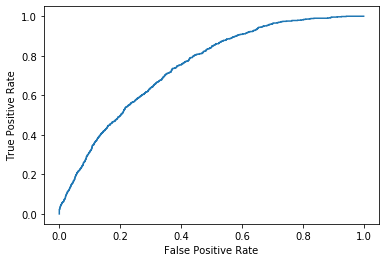

In [77]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probs)
temp = auc(fpr,tpr)
print(temp)

In [79]:
# Hyper parameter tuning
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from skopt.utils import use_named_args
from skopt import gp_minimize
space = [Integer(10, 60, name='n_estimators'),
         Integer(2, 40, name='max_features'),
         Categorical(['gini','entropy'], name='criterion')]

In [90]:
# Vaiable improtance plot
df_imp = pd.DataFrame()
df_imp['cls'] = X_train.columns
df_imp['imp'] = rf.feature_importances_

In [91]:
# Ranking attributes
df = df_imp.sort_values('imp',ascending=False)

In [92]:
#  Dependency between number of top attributes selected and AUC
cls = list(X_train.columns)
r=[]
num = []
for i in range(1,len(cls),1):
    c = df_imp[:i]['cls'].tolist()
    print(c)
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train[c],Y_train)
    probs = rf.predict_proba(X_test[c])[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    a=auc(fpr,tpr)
    print(a)
    r.append(a)
    num.append(i)

['LOS']
0.5087894339838206
['LOS', 'blood']
0.511572646554399
['LOS', 'blood', 'circulatory']
0.5230768731426315
['LOS', 'blood', 'circulatory', 'congenital']
0.5305451656165652
['LOS', 'blood', 'circulatory', 'congenital', 'digestive']
0.5383245287526145
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine']
0.5542227582723894
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary']
0.566968995498823
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious']
0.5735937879344569
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury']
0.5919904497671513
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury', 'mental']
0.5976132856773771
['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc']
0.5995090510397368


Text(0.5, 1.0, 'Number of Attributes vs AUC')

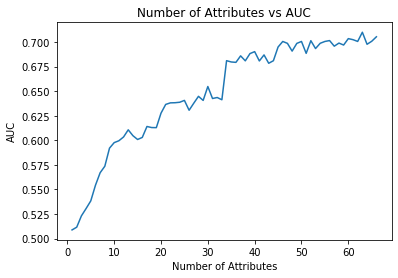

In [93]:
plt.plot(num,r)
plt.xlabel('Number of Attributes')
plt.ylabel('AUC')
plt.title('Number of Attributes vs AUC')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Random Search Training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

In [ ]:
rf_random.best_params_

In [ ]:
# Evaluating Random Search
rf = RandomForestClassifier(n_estimators = 1600,max_features = 'sqrt',max_depth = 20,min_samples_split = 10,min_samples_leaf = 1,bootstrap = True)
rf.fit(X_train, Y_train)
probs = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, probs)
temp = auc(fpr,tpr)
print(temp)

# 2.5% percent increase in AUC

In [95]:
# Logistic Regression fro different C values
# AUC on test data
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
num = [0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
auc = []
for i in num:
    lr = LogisticRegression(penalty = 'l2', C = i)
    print(i)
    lr.fit(X_train,Y_train)
    probs = lr.predict_proba(X_test)[:,1]
    temp = roc_auc_score(Y_test,probs)
    print(temp)
    auc.append(temp)

0.02
0.7055141039905589
0.04
0.71126177063602
0.06
0.713259841374735
0.08
0.7133160574000672
0.1
0.7130632800298087
0.2
0.7131768805428936
0.3
0.7120332154917344
0.4
0.7129437073754646
0.5
0.7134739296559657
0.6
0.7128687959514076


Text(0.5, 1.0, 'Logistic Regression for different C-Values on TestData')

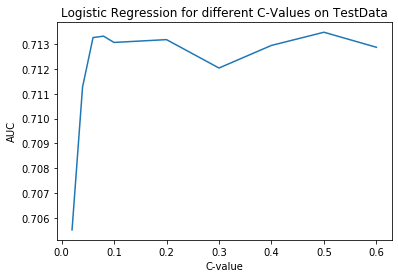

In [96]:
plt.plot(num,auc)
plt.xlabel('C-value')
plt.ylabel('AUC')
plt.title('Logistic Regression for different C-Values on TestData')

In [97]:
# Accuracy on test data
from sklearn.metrics import accuracy_score
num = [0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6]
auc = []
for i in num:
    lr = LogisticRegression(penalty = 'l2', C = i)
    print(i)
    lr.fit(X_train,Y_train)
    probs = lr.predict(X_train)
    temp = accuracy_score(Y_train,probs)
    print(temp)
    auc.append(temp)

0.02
0.941430476472705
0.04
0.941430476472705
0.06
0.9414093093156658
0.08
0.9413881421586267
0.1
0.9413881421586267
0.2
0.9413881421586267
0.3
0.9414093093156658
0.4
0.9413669750015875
0.5
0.9414093093156658
0.6
0.9413881421586267


Text(0.5, 1.0, 'Logistic Regression Accuracy for different C-values on Train Data')

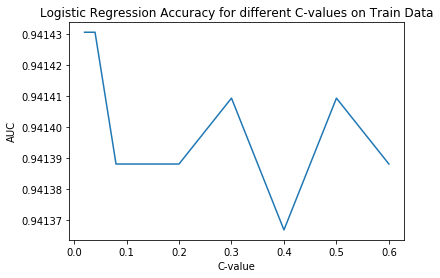

In [98]:
plt.plot(num,auc)
plt.xlabel('C-value')
plt.ylabel('AUC')
plt.title('Logistic Regression Accuracy for different C-values on Train Data')

In [186]:
lr = LogisticRegression()
cls = df1.columns
lr.fit(X_train,Y_train)
acc = []
for cnt in range(0,50,5):
    tt = df1[df1['LOS'] >= cnt] 
    ttt = tt[tt['LOS'] <= cnt + 5]
    y = ttt['Readmission_30']
    x = ttt.drop(columns = ['Readmission_30'])
    probs = lr.predict(x)
    temp = accuracy_score(probs,y)
    #probs = lr.predict(tt[cls])
    #temp = accuracy_score(probs,tt['Readmission_30'])
    print(temp)
    acc.append(temp)

0.9528761061946903
0.9413764738140937
0.9385804085908853
0.9292849631966351
0.9172320217096337
0.9159226190476191
0.8925831202046036
0.888695652173913
0.929471032745592
0.9166666666666666


Text(0, 0.5, 'Accuracy')

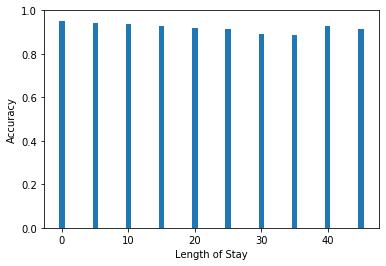

In [188]:
plt.bar(range(0,50,5),acc)
plt.xlabel('Length of Stay')
plt.ylabel('Accuracy')

In [189]:
lr = LogisticRegression()
cls = df1.columns
lr.fit(X_train,Y_train)
acc = []
for cnt in range(0,50,5):
    tt = df1[df1['LOS'] >= cnt] 
    ttt = tt[tt['LOS'] <= cnt + 5]
    y = ttt['Readmission_30']
    x = ttt.drop(columns = ['Readmission_30'])
    probs = lr.predict_proba(x)[:,1]
    temp = roc_auc_score(y,probs)
    #probs = lr.predict(x)
    #temp = accuracy_score(probs,y)
    #probs = lr.predict(tt[cls])
    #temp = accuracy_score(probs,tt['Readmission_30'])
    print(temp)
    acc.append(temp)

0.738119259450988
0.6898144180589169
0.6798150609150029
0.7227365221917836
0.681963182209609
0.6850175769034457
0.6883797909407665
0.7409784226190477
0.7139139139139139
0.7539238679415479


Text(0, 0.5, 'AUC')

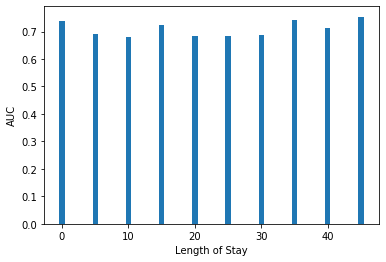

In [190]:
plt.bar(range(0,50,5),acc)
plt.xlabel('Length of Stay')
plt.ylabel('AUC')